<a href="https://colab.research.google.com/github/gitHubAndyLee2020/FinanceBERT/blob/main/financial_bert_monthly_prediction_training_from_embedding_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### FinancialBERT Monthly Prediction Training from Embedding v2

### Data Preparation

In [ ]:
# Upload training_data.jsonl file into a variable called "training_data"
# Upload zipped stock_data folder
from google.colab import files

uploaded = files.upload()

In [ ]:
!unzip stock_data.zip
!rm stock_data.zip

In [3]:
# Prepare stock price history data
import json
import os

# Path to your folder containing .jsonl files
folder_path = 'stock_data/'

# Initialize an empty list to store the dictionaries from all files
stock_price_history_data_list = []

# Iterate over each file in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.jsonl'):
        file_path = os.path.join(folder_path, filename)

        # Open and read each file
        with open(file_path, 'r') as file:
            for line in file:
                # Convert each line into a dictionary and append to the list
                stock_price_history_data_list.append(json.loads(line))

stock_price_history_data = {}

for entry in stock_price_history_data_list:
    if entry['stock'] not in stock_price_history_data:
        stock_price_history_data[entry['stock']] = {}
    stock_price_history_data[entry['stock']][entry['month_year']] = {
        'this_month_vw': entry['this_month_vw'],
        'next_month_vw': entry['next_month_vw'],
        'percentage_change': entry['percentage_change'],
    }

In [4]:
# Prepare training data
import json

# Path to your .jsonl file
file_path = 'cleaned_training_data.jsonl'

# Initialize an empty list to store the dictionaries
training_data_list = []

# Open the file and read line by line
with open(file_path, 'r') as file:
    for line in file:
        # Convert each line into a dictionary and append to the list
        training_data_list.append(json.loads(line))

training_data = {}

for entry in training_data_list:
    if entry['stock'] not in training_data:
        training_data[entry['stock']] = {}
    training_data[entry['stock']][entry['month_year']] = entry['data']

In [5]:
stock_price_history_data['A']['2019-02'], training_data['A']['2019-02']

({'this_month_vw': 77.448,
  'next_month_vw': 80.0518,
  'percentage_change': 0.03361997727507498},
 [{'title': 'Barclays Maintains Overweight on Agilent Technologies, Raises Price Target to $83',
   'date': '2019-02-21 08:00:00-05:00'},
  {'title': 'UPDATE: Agilent Raises FY19 Adj. EPS Guidance From $3-$3.05 To $3.03-$3.07 vs $3.05 Estimate, Sales From $5.13B-$5.17B To $5.15B-$5.19B vs $5.17B Est.',
   'date': '2019-02-20 16:07:00-05:00'},
  {'title': 'Agilent Sees Q2 Adj. EPS $0.70-$0.72 vs $0.72 Estimate, Sales $1.255B-$1.27B vs $1.27B Est.; Raises FY19 Guidance',
   'date': '2019-02-20 16:06:00-05:00'},
  {'title': 'Agilent Technologies Q1 EPS $0.76 Beats $0.73 Estimate, Sales $1.284B Beat $1.27B Estimate',
   'date': '2019-02-20 16:05:00-05:00'},
  {'title': '10 Stocks To Watch For February 20, 2019',
   'date': '2019-02-20 04:33:00-05:00'},
  {'title': 'Earnings Scheduled For February 20, 2019',
   'date': '2019-02-20 04:04:00-05:00'},
  {'title': 'JANA 13F Shows Liquidated Stake

### Top-k Retrival

In [ ]:
!pip install faiss-cpu

In [7]:
import faiss
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

In [8]:
# Format train/test dataset
presplit_texts = []
presplit_targets = []
presplit_vectors = []

In [9]:
# Vectorization using TF-IDF
vectorizer = TfidfVectorizer()
all_texts = []

for ticker in stock_price_history_data.keys():
    for month_year in stock_price_history_data[ticker].keys():
        if month_year in training_data[ticker]:
            headlines = [item['title'] for item in training_data[ticker][month_year]]
            all_texts.extend(headlines)

vectorizer.fit(all_texts)

for ticker in stock_price_history_data.keys():
    for month_year in stock_price_history_data[ticker].keys():
        if month_year in training_data[ticker]:
            headlines = [item['title'] for item in training_data[ticker][month_year]]
            presplit_texts.append(headlines)
            presplit_targets.append(stock_price_history_data[ticker][month_year]['percentage_change'])
            presplit_vectors.append(vectorizer.transform(headlines).toarray())

In [10]:
from sklearn.model_selection import train_test_split

# Randomly split the dataset into train and test sets for texts, targets, and vectors
texts, test_texts, targets, test_targets, vectors, test_vectors = train_test_split(
    presplit_texts, presplit_targets, presplit_vectors, test_size=0.1, random_state=42
)

In [11]:
# Query (vectorized)
k = 5
query_text = ["latest stock prices news headlines"]
query_vector = vectorizer.transform(query_text).toarray().astype('float32')

In [ ]:
from tqdm import tqdm

top_k_texts = []

# Wrap the iteration over texts with tqdm
for i, group_vectors in enumerate(tqdm(vectors)):
    dimension = group_vectors.shape[1]
    index = faiss.IndexFlatL2(dimension)
    index.add(group_vectors.astype('float32'))
    D, I = index.search(query_vector, k)

    selected_texts = [texts[i][selected_index] for selected_index in I[0]]

    top_k_texts.append(selected_texts)

In [ ]:
from tqdm import tqdm

test_top_k_texts = []

# Wrap the iteration over texts with tqdm
for i, group_vectors in enumerate(tqdm(test_vectors)):
    dimension = group_vectors.shape[1]
    index = faiss.IndexFlatL2(dimension)
    index.add(group_vectors.astype('float32'))
    D, I = index.search(query_vector, k)

    selected_texts = [test_texts[i][selected_index] for selected_index in I[0]]

    test_top_k_texts.append(selected_texts)

### Model Definition

In [14]:
import torch
from torch import nn
from transformers import BertModel, BertTokenizer

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

In [16]:
class FinBERTRegressor(nn.Module):
    def __init__(self, finbert_model_name="ProsusAI/finbert", hidden_size=768, output_size=1):
        super(FinBERTRegressor, self).__init__()
        # Load the FinBERT model
        self.finbert = BertModel.from_pretrained(finbert_model_name)

        # Regression layer
        self.regressor = nn.Linear(hidden_size, output_size)

    def forward(self, input_ids, attention_mask, token_type_ids=None):
        # Get embeddings from FinBERT
        with torch.no_grad():  # No need to calculate gradients for FinBERT
            outputs = self.finbert(input_ids=input_ids, attention_mask=attention_mask)

        # We use the [CLS] token's embedding for regression
        cls_embedding = outputs.last_hidden_state[:, 0, :]

        # Pass through the regression layer
        return self.regressor(cls_embedding)

In [ ]:
model = FinBERTRegressor()
model.to(device)  # Move the model to the GPU

In [ ]:
tokenizer = BertTokenizer.from_pretrained("ProsusAI/finbert")

### Dataset Processing

In [ ]:
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from tqdm import tqdm  # Import tqdm

# Assuming 'texts' is your list of texts to be tokenized
input_ids = []
attention_masks = []

# Wrap the iteration over texts with tqdm
for group_text in tqdm(top_k_texts, desc="Tokenizing"):
    text = ". ".join(group_text) + "."
    encoded_dict = tokenizer.encode_plus(
                        text,
                        add_special_tokens=True,
                        max_length=64,
                        pad_to_max_length=True,
                        return_attention_mask=True,
                        return_tensors='pt',
                   )

    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
targets = torch.tensor(targets)

# Create TensorDataset
dataset = TensorDataset(input_ids, attention_masks, targets)

# DataLoader
batch_size = 16
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Loss function
loss_fn = nn.MSELoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-5)

In [ ]:
# Tokenize the test data
test_input_ids = []
test_attention_masks = []

for group_text in tqdm(test_top_k_texts, desc="Tokenizing Test Data"):
    text = ". ".join(group_text) + "."
    encoded_dict = tokenizer.encode_plus(
                        text,
                        add_special_tokens=True,
                        max_length=64,
                        pad_to_max_length=True,
                        return_attention_mask=True,
                        return_tensors='pt',
                   )

    test_input_ids.append(encoded_dict['input_ids'])
    test_attention_masks.append(encoded_dict['attention_mask'])

test_input_ids = torch.cat(test_input_ids, dim=0)
test_attention_masks = torch.cat(test_attention_masks, dim=0)
test_targets = torch.tensor(test_targets)

# Create TensorDataset for test data
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_targets)

# Create DataLoader for test data
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Training Loop

In [31]:
avg_train_loss_history = []
avg_test_loss_history = []
# Initialize variables to track the best test loss and corresponding epoch
best_test_loss = float('inf')
best_epoch = 0

In [32]:
start_epoch = 1 # inclusive
end_epoch = 51 # exclusive

In [ ]:
# Check if the model directory exists, if not, create it
model_dir = 'model'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Training Loop
for epoch in range(start_epoch, end_epoch):
    # Training Phase
    model.train()
    total_train_loss = 0

    progress_bar = tqdm(dataloader, desc=f'Epoch {epoch}/{end_epoch - 1}')
    for batch in progress_bar:
        b_input_ids, b_input_mask, b_labels = [b.to(device) for b in batch]
        optimizer.zero_grad()
        outputs = model(b_input_ids, b_input_mask)
        loss = loss_fn(outputs.squeeze(), b_labels.float())
        total_train_loss += loss.item()
        loss.backward()
        optimizer.step()
        progress_bar.set_description(f"Epoch {epoch}/{end_epoch - 1} - Train Loss: {loss.item():.2f}")

    avg_train_loss = total_train_loss / len(dataloader)
    avg_train_loss_history.append(avg_train_loss)
    print(f'Epoch {epoch}/{end_epoch - 1} - Avg Train Loss: {avg_train_loss:.2f}')

    # Evaluation Phase
    model.eval()
    total_test_loss = 0
    with torch.no_grad():
        for batch in test_dataloader:
            b_input_ids, b_input_mask, b_labels = [b.to(device) for b in batch]
            outputs = model(b_input_ids, b_input_mask)
            loss = loss_fn(outputs.squeeze(), b_labels.float())
            total_test_loss += loss.item()

    avg_test_loss = total_test_loss / len(test_dataloader)
    avg_test_loss_history.append(avg_test_loss)
    print(f'Epoch {epoch}/{end_epoch - 1} - Avg Test Loss: {avg_test_loss:.2f}')

    # Keep track of the best epoch
    if avg_test_loss < best_test_loss:
        best_test_loss = avg_test_loss
        best_epoch = epoch

    # Save the model weights
    model_save_path = os.path.join(model_dir, f'model_epoch_{epoch}.pth')
    torch.save(model.regressor.state_dict(), model_save_path)
    print(f'Model saved for epoch {epoch} at {model_save_path}')

### Examples Inputs & Outputs

In [ ]:
# Assuming 'model' is your PyTorch model and 'tokenizer' is your tokenizer
text = "Google stock rises 200% during this year's 3rd quarter."

# Tokenize the text
inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)

# Move the inputs to the same device as the model
inputs = {k: v.to(device) for k, v in inputs.items()}

# Generate output
output = model(**inputs)

print(f"Prediction is {abs(output.item()) * 100:.2f}% {'rise' if output.item() > 0 else 'fall'} in the stock price during next month.")

Prediction is 5.32% rise in the stock price during next month.


In [ ]:
# Assuming 'model' is your PyTorch model and 'tokenizer' is your tokenizer
text = "Google stock crashs and the company files for backruptcy"

# Tokenize the text
inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)

# Move the inputs to the same device as the model
inputs = {k: v.to(device) for k, v in inputs.items()}

# Generate output
output = model(**inputs)

print(f"Prediction is {abs(output.item()) * 100:.2f}% {'rise' if output.item() > 0 else 'fall'} in the stock price during next month.")

Prediction is 5.11% rise in the stock price during next month.


### Training Statistics

In [ ]:
# Print the best epoch and its test loss after all epochs are completed
print(f'Best epoch: {best_epoch} with Test Loss: {best_test_loss:.2f}')

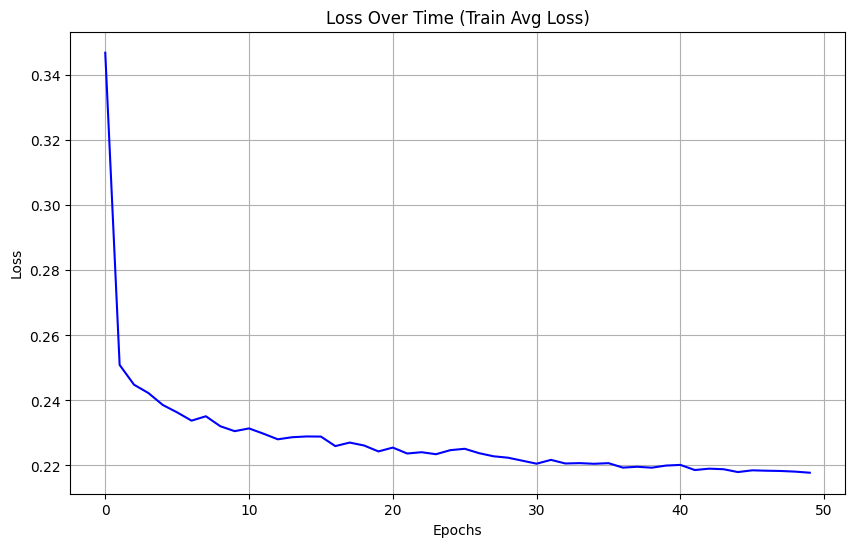

In [ ]:
import matplotlib.pyplot as plt

# Creating the plot
plt.figure(figsize=(10, 6))  # Optional: You can adjust the figure size
plt.plot(avg_train_loss_history, linestyle='-', color='b')  # Line plot without markers

# Adding title and labels
plt.title('Loss Over Time (Train Avg Loss)')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Optionally, add a grid for easier reading
plt.grid(True)

# Show the plot
plt.show()

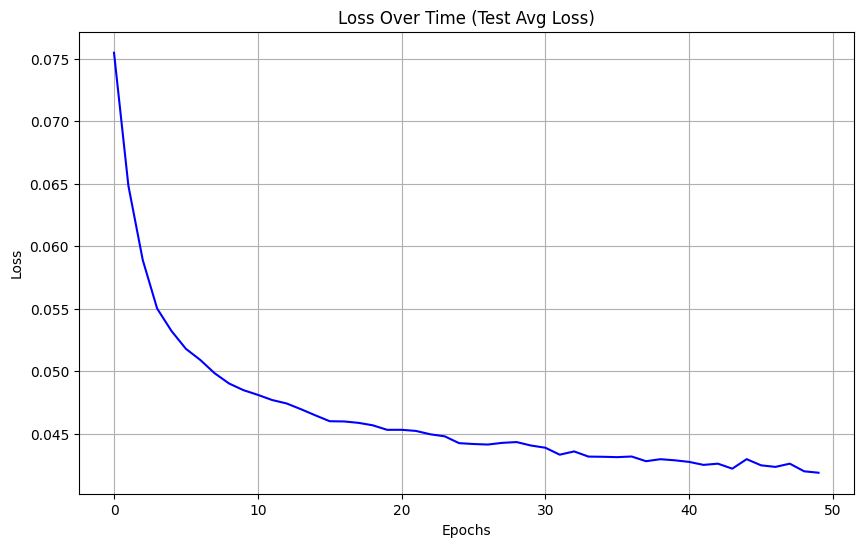

In [ ]:
import matplotlib.pyplot as plt

# Creating the plot
plt.figure(figsize=(10, 6))  # Optional: You can adjust the figure size
plt.plot(avg_test_loss_history, linestyle='-', color='b')  # Line plot without markers

# Adding title and labels
plt.title('Loss Over Time (Test Avg Loss)')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Optionally, add a grid for easier reading
plt.grid(True)

# Show the plot
plt.show()

### Model Information

In [ ]:
# Calculate the number of parameters
total_params = sum(p.numel() for p in model.regressor.parameters())

print(f"Total number of parameters: {total_params}")

In [ ]:
!ls -lh model/model_epoch_1.pth

### Downloading Model Data

In [ ]:
import json
from google.colab import files

# Example dictionary
data = {
    'batch_size': batch_size,
    'learning_rate': 1e-5,
    'num_epochs': 50,
    'best_epoch': best_epoch,
    'best_test_loss': best_test_loss,
    'avg_train_loss_history': avg_train_loss_history,
    'avg_test_loss_history': avg_test_loss_history,
}

# Convert dictionary to JSON formatted string
json_data = json.dumps(data, indent=4)

# Write JSON data to a file
filename = 'model_training_data_v2.json'
with open(filename, 'w') as file:
    file.write(json_data)

# Download the file to your local system
files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Download the best model weight to your local system
files.download(f'model/model_epoch_{best_epoch}.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>